# comma package tutorial

In [2]:
from comma.model import Model
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', None)

### Step 1. Initialise the model


We initialise a model with: 

- A population size of 500 individuals. 

- Population parameters estimated via IPF(`use_ipf = True`). Note that if the joint probabilities are not necessary, then `use_ipf = False` will load parameters specified in `params_individual.json`. This will initiate a sampling from the distribution outlined in the json file, which does *not* take into account the joint probabilities within variables.

- Seed = 0. This will ensure reproducibility in the output.

- dir_params = '../parameters'. This is the folder containing all our configuration files: matrices of action probabilities, parameters of population composition and matrices of the effects of actions on mental health

In [31]:
size = 500
dir_params = '../parameters/'
use_ipf = True
seed = 0

model = Model(size, dir_params, use_ipf, seed)

Populating individuals: 100%|███████████████| 500/500 [00:00<00:00, 22093.42i/s]


To see who are the agents, you can print their features:

In [32]:
print(f'there are {len(model.agents)} individuals')

there are 500 individuals


In [33]:
print(f'these are the feature of one individual: \n\n{model.agents[0].get_features()}')

these are the feature of one individual: 

baseline                              1
age_group__1                          1
age_group__2                          0
age_group__3                          0
age_group__4                          0
gender_f                              0
gender_m                              1
education_high                        1
education_low                         0
education_medium                      0
unemployed_no                         0
unemployed_yes                        1
have_partner_no                       1
have_partner_yes                      0
depressed_no                          1
depressed_yes                         0
children_presence_no                  1
children_presence_yes                 0
housing_financial_difficulties_no     1
housing_financial_difficulties_yes    0
selfrated_health_average              0
selfrated_health_good                 1
selfrated_health_poor                 0
critical_job_no                      

### Step 2. Run the model

We simulate the mental health trajectory of the individuals generated above across 200 days (1 step = 1 day). Within these days, we hypothesise 4 types of lockdowns: absent, easy, hard and medium, consecutively and each one of them lasting 50 days.

In [34]:
steps = 200

n = steps // 4
lockdown_pattern = ["absent"]*n + ["easy"]*n + ["hard"]*n + ["medium"]*n

In [35]:
model.run(steps=steps, lockdown_policy=lockdown_pattern, out_path="simulation_results.csv")

Running simulation: 100%|█████████████████████| 200/200 [00:22<00:00,  9.08it/s]


In [19]:
print(f'We simulated {len(lockdown_pattern)} days')

We simulated 200 days


The model at the end of the run will output "simulation_results.csv". 

### Step 3. Load and Plot the results

In [36]:
data = pd.read_csv('simulation_results.csv', delimiter=";", decimal=",")

In [37]:
display(data.head())

,step_id,lockdown,agent_id,delta_mental_health,cumulative_mental_health,covid_status,days_since_first_infection
0,0,absent,0,0.0,0.00,0,NaN
1,0,absent,1,0.0,-2.17,0,NaN
2,0,absent,2,0.0,-6.46,0,NaN
3,0,absent,3,0.0,0.00,0,NaN
4,0,absent,4,0.0,0.00,0,NaN


In [38]:
data['lockdown'].unique()

array(['absent', 'easy', 'hard', 'medium'], dtype=object)

#### Group by step_id and compute the average mental health score

In [39]:
grouped_data = data.groupby(['step_id', 'lockdown']).mean().reset_index()
grouped_data

,step_id,lockdown,agent_id,delta_mental_health,cumulative_mental_health,covid_status,days_since_first_infection
0,0,absent,249.5,0.00000,-2.523520,0.0,NaN
1,1,absent,249.5,-2.55186,-5.077353,0.0,NaN
2,2,absent,249.5,-2.57328,-7.652617,0.0,NaN
3,3,absent,249.5,-2.70408,-10.358703,0.0,NaN
4,4,absent,249.5,-2.69746,-13.058195,0.0,NaN
...,...,...,...,...,...,...,...
195,195,medium,249.5,-22.93730,-2859.679686,0.0,0.0
196,196,medium,249.5,-22.66270,-2882.344391,0.0,0.0
197,197,medium,249.5,-22.53890,-2904.885301,0.0,0.0
198,198,medium,249.5,-22.54628,-2927.433598,0.0,0.0


In [45]:
print(f"There have been {data['covid_status'].sum()} infected individuals")

There have been 85 infected individuals


In [47]:
print(f"There have been {data['days_since_first_infection'].sum()} days in which individuals had covid")

There have been 568.0 days in which individuals had covid


In [49]:
print(f"The maximum duration of the infection was {data['days_since_first_infection'].max()} days")

The maximum duration of the infection was 14.0 days


### Cumulative mental health across time per agent

In [50]:
agg_df = data.groupby(['step_id', 'lockdown'])['cumulative_mental_health'].mean().reset_index()
agg_df['label'] = 'average mental health'

few_points = data[data['agent_id'] <= 3]
other_points = data[data['agent_id'] > 3]

max_step_ids = data.groupby('lockdown')['step_id'].max().reset_index()


In [51]:
# Create a dictionary with a unique color for each agent_id
colors = {}
unique_agents = data['agent_id'].unique()
for agent in unique_agents:
    if agent <= 3:
        colors[agent] = {0: "#386cb0", 1: "#fdb462", 2: "#7fc97f", 3: "darkred"}[agent]
    else:
        colors[agent] = "gainsboro"


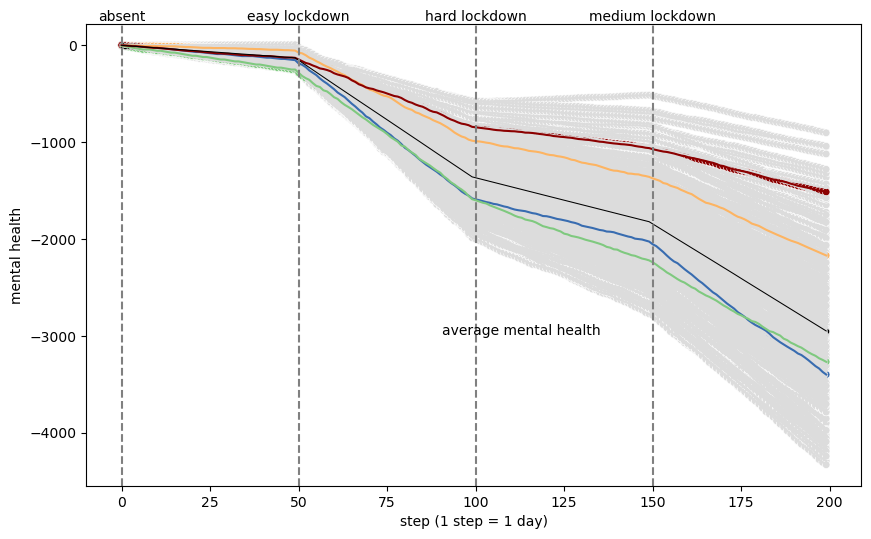

In [52]:
fig, ax = plt.subplots(figsize=(10, 6))

# other_points
sns.lineplot(data=other_points, x='step_id', y='cumulative_mental_health', hue='agent_id', palette=colors, legend=False)
sns.scatterplot(data=other_points, x='step_id', y='cumulative_mental_health', hue='agent_id', palette=colors, s=30, legend=False)

# few_points
sns.lineplot(data=few_points, x='step_id', y='cumulative_mental_health', hue='agent_id', palette=colors, ax=ax)
sns.scatterplot(data=few_points, x='step_id', y='cumulative_mental_health', hue='agent_id', palette=colors, s=30, ax=ax)

# agg_df
sns.lineplot(data=agg_df, x='step_id', y='cumulative_mental_health', color='black', ax=ax, size=2)
sns.scatterplot(data=agg_df, x='step_id', y='cumulative_mental_health', color='black', s=20, ax=ax)

vector = [i * n for i in range(4)]

# add lockdown labels and dotted lines
for x_val, label in zip(vector, ['absent', 'easy lockdown', 'hard lockdown', 'medium lockdown']):
    ax.axvline(x=x_val, linestyle='--', color='gray')
    ax.text(x=x_val, y=ax.get_ylim()[1], s=label, va='bottom', ha='center')

avg_mh_text_y = agg_df[agg_df['step_id'] == agg_df['step_id'].max()]['cumulative_mental_health'].values[0]
ax.text(113, avg_mh_text_y, 'average mental health', va='center', ha='center', color='black')

ax.set_xlabel('step (1 step = 1 day)')
ax.set_ylabel('mental health')
ax.get_legend().remove()

plt.show()


### Average mental health for each step coloured by lockdown type

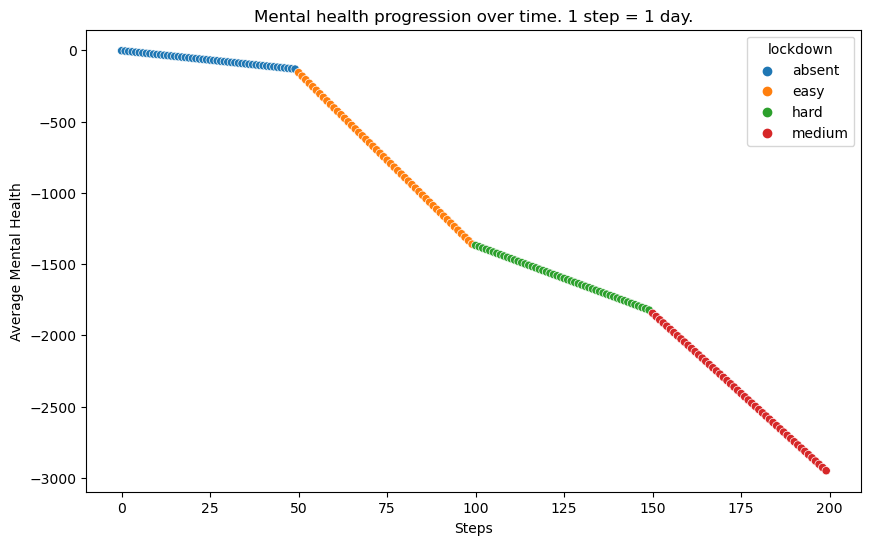

In [53]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=grouped_data, x='step_id', y='cumulative_mental_health', hue='lockdown')
plt.xlabel('Steps')
plt.ylabel('Average Mental Health')
plt.title('Mental health progression over time. 1 step = 1 day.')
plt.show()